# Assignment Part 2:
# B. Logistic Regression on BreastMNIST

Import all required libraries

In [1]:
# import ...
import medmnist
from medmnist import INFO, Evaluator

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torchvision
from torchvision import transforms, datasets

import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering

import matplotlib.pyplot as plt
import numpy as np

import random
import time


Set the random seed as my student card number ( from the first non-zero digit ).<br>Set the computation environment.

In [2]:
# set the random seed, I use my Ucard number as random seed. (from the first non-zero digit)
random.seed(1761506)
np.random.seed(1761506)
torch.manual_seed(1761506)

# set the computation device, to ensure the compatibility, I remove the choice to use GPU.
device = torch.device("cpu")

## B.1 Data loading and inspection
Load the breastMNIST dataset and then, encapsulate the dataset into two sets of dataloader, one for logistic regression model by sklearn and one for LR model by pytorch.

In [3]:
# load breastMNIST data and encapsulate them into two types of dataloader, one data loader is
# for scikit learn method and one for pytorch method
data_flag_breast = "breastmnist"
batch_size_breast = 128
info_breast = INFO[data_flag_breast]


# load breastMNIST data
DataClass_breast = getattr(medmnist, info_breast["python_class"])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

# load data
train_dataset_breast = DataClass_breast(split = "train", 
                                        download = True, 
                                        transform = data_transform)
test_dataset_breast = DataClass_breast(split = "test", 
                                        download = True, 
                                        transform = data_transform)
val_dataset_breast = DataClass_breast(split = "val", 
                                        download = True, 
                                        transform = data_transform)

# encapsulate data into dataloader form (for sklearn method (B2.a))
train_loader_breast_s = DataLoader(dataset = train_dataset_breast,
                                  batch_size = len(train_dataset_breast),
                                  shuffle = False)
test_loader_breast_s = DataLoader(dataset = test_dataset_breast,
                                  batch_size = len(test_dataset_breast),
                                  shuffle = False)
val_loader_breast_s = DataLoader(dataset = val_dataset_breast,
                                  batch_size = len(val_dataset_breast),
                                  shuffle = False)

# encapsulate data into dataloader for (for pytorch method (B2.b))
train_loader_breast_p = DataLoader(dataset = train_dataset_breast,
                                  batch_size = batch_size_breast,
                                  shuffle = True)
train_loader_eval_breast_p = DataLoader(dataset = train_dataset_breast,
                                    batch_size = 2*batch_size_breast,
                                    shuffle = False)
test_loader_breast_p = DataLoader(dataset = test_dataset_breast,
                              batch_size = 2*batch_size_breast,
                              shuffle = False)
val_loader_breast_p = DataLoader(dataset = val_dataset_breast,
                             batch_size = 2*batch_size_breast,
                             shuffle = False)


Using downloaded and verified file: /home/songyangli/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/songyangli/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/songyangli/.medmnist/breastmnist.npz


Display 20 images for each class respectively from training, test, and validation dataset.

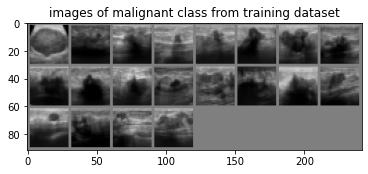

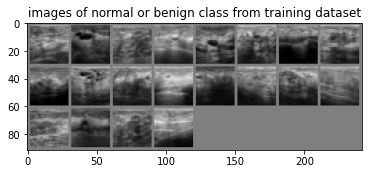

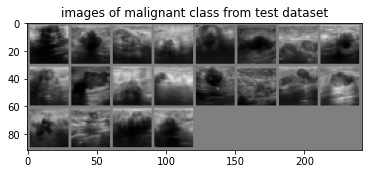

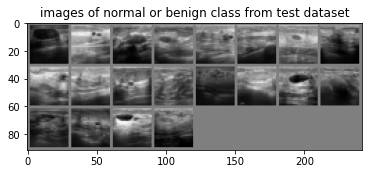

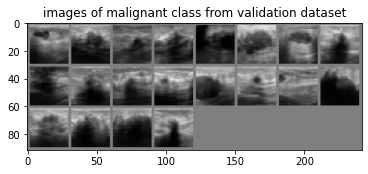

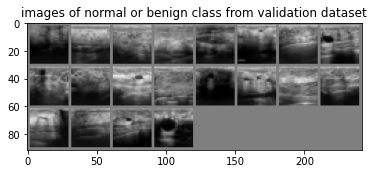

In [4]:
# define a function to sample and arrange the image from one class from a dataset
def imgarrange_breast(dataloader):
    data = next(iter(dataloader))
    img_0 = torch.zeros((20, 1, 28, 28)) # store the image from class 0
    img_1 = torch.zeros((20, 1, 28, 28)) # store the image from class 1
    
    num_0 = 0
    num_1 = 0
    
    for i in range(data[1].size(0)):
        if (data[1][i, 0] == 0)&(num_0 <= 19):
            img_0[num_0, :, :, :] = data[0][i, :, : ,:]
            num_0 += 1
        elif (data[1][i, 0] == 1)&(num_1 <= 19):
            img_1[num_1, :, :, :] = data[0][i, :, :, :]
            num_1 += 1
        if (num_0 == 20)&(num_1 == 20):
            break
    
    return img_0, img_1

# define a function to display image
def imgshow_breast(img, class_name, dataset_name):
    img = img/2.0 + 0.5
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, cmap = "gray")
    plt.title("images of {} class from {} dataset".format(class_name, dataset_name))
    plt.show()

# inspect images from training dataset
img_0_train_breast, img_1_train_breast = imgarrange_breast(train_loader_breast_s)
imgshow_breast(torchvision.utils.make_grid(img_0_train_breast), "malignant", "training")
imgshow_breast(torchvision.utils.make_grid(img_1_train_breast), "normal or benign", 
               "training")

# inspect images from test dataset
img_0_test_breast, img_1_test_breast = imgarrange_breast(test_loader_breast_s)
imgshow_breast(torchvision.utils.make_grid(img_0_test_breast), "malignant", "test")
imgshow_breast(torchvision.utils.make_grid(img_1_test_breast), "normal or benign", "test")

# inspect images from validation dataset
img_0_val_breast, img_1_val_breast = imgarrange_breast(val_loader_breast_s)
imgshow_breast(torchvision.utils.make_grid(img_0_val_breast), "malignant", "validation")
imgshow_breast(torchvision.utils.make_grid(img_1_val_breast), "normal or benign"
               , "validation")

## B.2 Logistic regression
### B.2.a)

Using the built-in logistic regression functions in scikit-learn to train a logistic regression model with L2 regularization on training set. 
<br> Using GridSearchCV and validation dataset to find the best l2 hyperparameter from a candidate list.

In [5]:
# reshape the data format from 1x28x28 to 1x764 for sklearn logistic regression model
train_data_breast_s = next(iter(train_loader_breast_s))
train_x_breast_s = train_data_breast_s[0].view(train_data_breast_s[0].size(0), -1).numpy()
train_y_breast_s = train_data_breast_s[1].squeeze(1).numpy()

test_data_breast_s = next(iter(test_loader_breast_s))
test_x_breast_s = test_data_breast_s[0].view(test_data_breast_s[0].size(0), -1).numpy()
test_y_breast_s = test_data_breast_s[1].squeeze(1).numpy()

val_data_breast_s = next(iter(val_loader_breast_s))
val_x_breast_s = val_data_breast_s[0].view(val_data_breast_s[0].size(0), -1).numpy()
val_y_breast_s = val_data_breast_s[1].squeeze(1).numpy()


# prepare the basic arguments for GridSearchCV to find the best l2 hyperparameter
whole_x_breast_s = np.vstack((train_x_breast_s, val_x_breast_s))
whole_y_breast_s = np.hstack((train_y_breast_s, val_y_breast_s))

val_fold = np.zeros((whole_x_breast_s.shape[0], 1))
val_fold[0:train_x_breast_s.shape[0], 0] = -1
pre_split = PredefinedSplit(val_fold)

C = [0.00001, 0.01, 0.05, 0.1, 1] # candidate list for l2 hyperparameter

param_grid = dict(C = C)

# choose the best l2 hyperparameter by using GridSearchCV for logistic regresshion model
gridcv = GridSearchCV(LogisticRegression(penalty = "l2", solver = "sag", max_iter = 1000),
                     param_grid = param_grid, cv = pre_split)
gridcv.fit(whole_x_breast_s, whole_y_breast_s)

# report the best l2 regularization hyperparameter 
print("The best l2 regularization hyperparameter for the logistic regression model built by sklearn is :")
print(gridcv.best_params_)

The best l2 regularization hyperparameter for the logistic regression model built by sklearn is :
{'C': 0.05}


Now, we have chosen the best l2 regularization hyperparameter by using validation dataset and we can use it to train a model and get the training accuracy, validation accuracy, and test accuracy of this model.

In [6]:
# define a logistic regression model by using sklearn
logreg_s = LogisticRegression(penalty = "l2", C = gridcv.best_params_["C"],
                             solver = "sag", max_iter = 300)

# fit the training dataset to train the model
logreg_s.fit(train_x_breast_s, train_y_breast_s)

# report the training accuracy, validation accuracy, and test accuracy of this model
training_accuracy_breast_s = logreg_s.score(train_x_breast_s, train_y_breast_s)
validation_accuracy_breast_s = logreg_s.score(val_x_breast_s, val_y_breast_s)
testing_accuracy_breast_s = logreg_s.score(test_x_breast_s, test_y_breast_s)

print("the training accuracy of logistic regression model by sklearn is :\n \
{}%".format(100*training_accuracy_breast_s))
print("the validation accuracy of logistic regression model by sklearn is :\n \
{}%".format(100*validation_accuracy_breast_s))
print("the testing accuracy of logistic regression model by sklearn is :\n \
{}%".format(100*testing_accuracy_breast_s))

the training accuracy of logistic regression model by sklearn is :
 84.24908424908425%
the validation accuracy of logistic regression model by sklearn is :
 85.8974358974359%
the testing accuracy of logistic regression model by sklearn is :
 80.12820512820514%


### B.2.b)

Using Pytorch to train a logistic regression model with L2 regularization

In [7]:
# set the basic parameters and hypeparameters for logistic regression model by pytorch
learning_rate_breast = 0.03
max_epochs_breast = 300
lambda_breast_candidate = [0.0001, 0.001, 0.01] # the L2 regularization hyperparameter candidates

#    we have defined the dataloader for pytorch logistic regression model at the begining of 
# this question

# define the logistic regression by a single neuron
class LogReg(nn.Module):
    def __init__(self):
        super(LogReg, self).__init__()
        self.layer = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 1), nn.Sigmoid()
        )
    
    def forward(self, x):
        out = self.layer(x)
        
        return out


# define a evaluation function to compute the training, validation, or testing accuracy
def eval_breast_p(dataloader, logreg_p):
    total, correct = 0, 0
    logreg_p.eval()
    
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            labels = labels.type(torch.float)
            inputs, labels = inputs.to(device), labels.to(device)
            preds = logreg_p(inputs)
            preds = preds.round()
            
            total += labels.size(0)
            correct += (preds == labels).sum().item()
    
    return (correct/total)*100


# using the validation dataset to choose the best L2 regularization hyperparameter
def validation_breast_p(train_dataloader, val_dataloader, lambda_breast_candidate):
    validation_accuracy_set = [] # store the validation accuracies for models under 
                                 # different l2 hyperparameters
    train_accuracy_set = []
    test_accuracy_set = []
    model_parameters_set = [] # store the parameters for each model under different l2
                              # hyperparameters
    
    for l2_hyper in lambda_breast_candidate:
        logreg_p = LogReg().to(device)
    
        # add the L2 regularization to the model
        # note we only impose a L2 weight decay to parameter "weights", not to "biases"
        weight_decay_list = (param for name, param in logreg_p.named_parameters() \
                             if name[-4:] != "bias" and "bn" not in name)
        no_decay_list = (param for name, param in logreg_p.named_parameters() \
                         if name[-4:] == "bias" or "bn" in name)
        parameters = [{'params': weight_decay_list, "weight_decay": l2_hyper},
                  {'params': no_decay_list, "weight_decay": 0.}]
        
        criterion = nn.BCELoss()
        # the "weight" parameters will be affected by the l2 regularization
        optimizer = optim.SGD(parameters, lr = learning_rate_breast) 
        
        # training the model by training dataset and one selected l2 regularization hyperparameter
        for epoch in range(max_epochs_breast):
            for data in train_dataloader:
                inputs, labels = data
                labels = labels.type(torch.float)
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = logreg_p(inputs)
                loss = criterion(preds, labels)
                loss.backward()
                optimizer.step()
        
        # store the validation accuracy under different l2 regularization hyperparameters
        validation_accuracy_set.append(eval_breast_p(val_dataloader, logreg_p))
    
    # choose the best l2 regularization hyperparameter
    best_index = np.argmax(validation_accuracy_set)
    best_l2_hyper = lambda_breast_candidate[best_index]
    
    return best_l2_hyper


# report the best l2 regularization hyperparameter
best_lambda_breast = validation_breast_p(train_loader_breast_p, 
                                         val_loader_breast_p, 
                                         lambda_breast_candidate)

print("The best l2 regularization hyperparameter for the logistic regression model built by pytorch is :")
print(best_lambda_breast)
    

The best l2 regularization hyperparameter for the logistic regression model built by pytorch is :
0.001


Now, we have chosen the best l2 regularization hyperparameter and we can use it to train a model by pytorch.
<br> Then, we could get the training accuracy, validation accuracy, and testing accuracy of this model with the chosen hyperparameter.

In [8]:
# produce a logistic regression model
best_lr = LogReg().to(device)

#     add the L2 regularization to the model, note we only impose a L2 weight decay to 
# parameter "weights", not to "biases"
best_lr_weight_decay_list = (param for name, param in best_lr.named_parameters() \
                     if name[-4:] != 'bias' and "bn" not in name)
best_lr_no_decay_list = (param for name, param in best_lr.named_parameters() \
                 if name[-4:] == 'bias' or "bn" in name)
best_lr_parameters = [{'params': best_lr_weight_decay_list},
                      {'params': best_lr_no_decay_list, 'weight_decay': 0.}]

# choose the loss function 
best_lr_criterion = nn.BCELoss()

# choose the optimizer
# the "weight" parameters will be affected by the l2 regularization
best_lr_optimizer = optim.SGD(best_lr_parameters, lr = learning_rate_breast,
                      weight_decay = best_lambda_breast) 

# train this model by using the parameters and hyperparameters we have already chosen
for epoch in range(max_epochs_breast):
    for data in train_loader_breast_p:
        inputs, labels = data
        best_lr_optimizer.zero_grad()
        labels = labels.type(torch.float)
        inputs, labels = inputs.to(device), labels.to(device)
        preds = best_lr(inputs)
        loss = best_lr_criterion(preds, labels)
        loss.backward()
        best_lr_optimizer.step()
    

# report the training accuracy, testing accuracy, and validation accuracy on this chosen 
# model
training_accuracy_breast_p = eval_breast_p(train_loader_breast_p, best_lr)
validation_accuracy_breast_p = eval_breast_p(val_loader_breast_p, best_lr)
testing_accuracy_breast_p = eval_breast_p(test_loader_breast_p, best_lr)

print("the training accuracy of logistic regression model by pytorch is :\n \
{}%".format(training_accuracy_breast_p))
print("the validation accuracy of logistic regression model by pytorch is :\n \
{}%".format(validation_accuracy_breast_p))
print("the testing accuracy of logistic regression model by pytorch is :\n \
{}%".format(testing_accuracy_breast_p))

the training accuracy of logistic regression model by pytorch is :
 83.33333333333334%
the validation accuracy of logistic regression model by pytorch is :
 84.61538461538461%
the testing accuracy of logistic regression model by pytorch is :
 82.6923076923077%


## B.3 Performance comparison
### B.3.a)
Summarize each of the three metrics from the two models in B.2 by using bar graph.

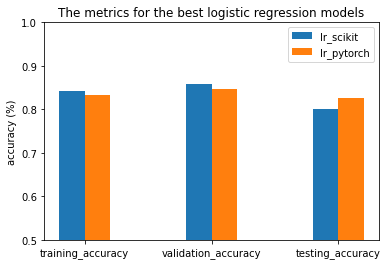

In [9]:
y_s = [training_accuracy_breast_s, validation_accuracy_breast_s, testing_accuracy_breast_s]
x_s_1 = np.array([2, 4, 6])
x_s = ["training_accuracy", "validation_accuracy", "testing_accuracy"]
y_p = [training_accuracy_breast_p/100, validation_accuracy_breast_p/100, testing_accuracy_breast_p/100]

plt.figure()
plt.bar(x_s_1 - 0.2, y_s, width = 0.4, label = "lr_scikit")
plt.bar(x_s_1 + 0.2, y_p, width = 0.4, label = "lr_pytorch")
plt.xticks([2, 4, 6], ["training_accuracy", "validation_accuracy", "testing_accuracy"])
plt.ylim([0.5, 1.0])
plt.ylabel("accuracy (%)")
plt.legend()
plt.title("The metrics for the best logistic regression models")
plt.show()

### B.3.b)
Describe at leat two observations interesting.

(i): In both logistic regression model built by sklearn library or pytorch library, we could easily find when the l2 regularization hyperparameter is zero or extremely small, the "weight" parameters could not be restrained. In this case, the model might be overfitted and the training accuracy would be very large and sometimes could reach 99% or even 100%. Reversely, the validation accuracy and testing accuracy could be in range 65% to 75% when we don't have a reasonable l2 regularization. 
<br>
<br>     Therefore, it is necessary to regularize the model to prevent the overfitting. However, if the l2 regularization hyperparameter is set too large, then the regularization is too strong and the model might be underfitted. In this case, all the three metrics would be relatively low - in a range from 65% to 75% for all three metrics
<br>
<br>
     

(ii): In the process to adjust the l2 regularization hyperparamter of logistic regression model built by pytorch, I find three different methods. 
<br>
<br>The first one is to directly tune the argument named "weight_decay" in the optimizer. If we test it carefully by checking the change of models' parameters, we could find that adjusting "weight_decay" will simultaneously decrease the "weight" and "bias". However, commonly, we only hope the parameters "weight" are restrained in regularization process.
<br>
<br>Therefore, I choose the second method - to impose the "weight_decay" separately. That is to say, only restraining the paramters "weights" and the "bias" would not be influenced.
<br>
<br>For the third method, we could directly add a l2 regularization term in the equation to calculate loss in the training loop.
<br>
<br>

(iii): In the process to build a logistic regression model by pytorch library, it seems like we use a simplest neural network - only one layer and one neuron - to construct the mathematics procedure of logistic regression. Therefore, the underlying principle of logistic regression models built by sklearn or pytorch should be same and it is the reason for why the optimal metrics from two models are very close.


# C. Convolutional Neural Networks on OCTMNIST
## C.1 Data loading and inspection


In [10]:
# load OCTMNIST dataset and encapsulate them into dataloader
data_flag_oct = "octmnist"
batch_size_oct = 64
info_oct = INFO[data_flag_oct]


# load OCTMNIST data
DataClass_oct = getattr(medmnist, info_oct["python_class"])

data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.2], std = [0.2])
])

data_transform_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.2], std = [0.2])
])


# load data
train_dataset_oct = DataClass_oct(split = "train", 
                                  download = True,
                                  transform = data_transform)
test_dataset_oct = DataClass_oct(split = "test",
                                download = True,
                                transform = data_transform)
val_dataset_oct = DataClass_oct(split = "val",
                                download = True, 
                                transform = data_transform)

# load a training dataset after augmentation, the augmentation technique is RandomHorizontalFlip()
train_dataset_oct_aug = DataClass_oct(split = "train", 
                                  download = True,
                                  transform = data_transform_aug)


# encapsulate the dataset into dataloader
train_loader_oct = DataLoader(dataset = train_dataset_oct,
                             batch_size = batch_size_oct,
                             shuffle = True)
train_loader_eval_oct = DataLoader(dataset = train_dataset_oct,
                                  batch_size = 2*batch_size_oct,
                                  shuffle = False)
test_loader_oct = DataLoader(dataset = test_dataset_oct,
                            batch_size = 2*batch_size_oct,
                            shuffle = False)
val_loader_oct = DataLoader(dataset = val_dataset_oct,
                           batch_size = 2*batch_size_oct,
                           shuffle = False)
# encapsulate a training dataset after augmentation into a special dataloader
train_loader_oct_aug = DataLoader(dataset = train_dataset_oct_aug,
                                  batch_size = batch_size_oct,
                                  shuffle = True)

# encapsulate three dataloader with full length batch_size to prepare data for displaying
train_loader_oct_dis = DataLoader(dataset = train_dataset_oct,
                                 batch_size = len(train_dataset_oct),
                                 shuffle = False)
test_loader_oct_dis = DataLoader(dataset = test_dataset_oct,
                                batch_size = len(test_dataset_oct),
                                shuffle = False)
val_loader_oct_dis = DataLoader(dataset = val_dataset_oct,
                               batch_size = len(val_dataset_oct),
                               shuffle = False)

Using downloaded and verified file: /home/songyangli/.medmnist/octmnist.npz
Using downloaded and verified file: /home/songyangli/.medmnist/octmnist.npz
Using downloaded and verified file: /home/songyangli/.medmnist/octmnist.npz
Using downloaded and verified file: /home/songyangli/.medmnist/octmnist.npz


Display 20 images for each class from the training set.

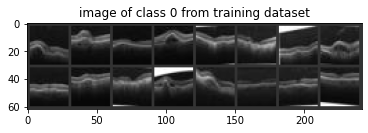

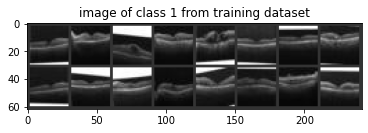

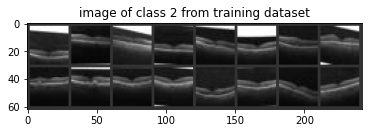

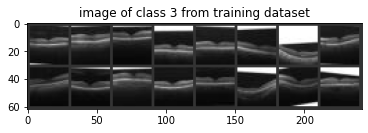

In [11]:
#    Define a function to sample image from each class and arrange the images in the
# same class together

def imgarrange_oct(dataloader):
    data = next(iter(dataloader))
    # define for list to store the image from four different class
    img_0 = []
    img_1 = []
    img_2 = []
    img_3 = []
    
    num_0 = 0
    num_1 = 0
    num_2 = 0
    num_3 = 0
    
    for i in range(data[1].size(0)):
        if (data[1][i, 0] == 0) & (num_0 <= 15):
            img_0.append(data[0][i, :, :, :])
            num_0 += 1
        
        elif (data[1][i, 0] == 1) & (num_1 <= 15):
            img_1.append(data[0][i, :, :, :])
            num_1 += 1
        
        elif (data[1][i, 0] == 2) & (num_2 <= 15):
            img_2.append(data[0][i, :, :, :])
            num_2 += 1
        
        elif (data[1][i, 0] == 3) & (num_3 <= 15):
            img_3.append(data[0][i, :, :, :])
            num_3 += 1
        
        if (num_0 == 16) & (num_1 == 16) & (num_2 == 16) & (num_3 == 16):
            break
    
    return (img_0, img_1, img_2, img_3)


# Define a function to display image
def imgshow_oct(timg, class_name, dataset_name):
    timg = timg/5 + 0.2
    npimg = timg.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    plt.imshow(npimg, cmap = "gray")
    plt.title("image of class {} from {} dataset".format(class_name, dataset_name))
    plt.show()

# inspect images from training dataset
img_0_oct, img_1_oct, img_2_oct, img_3_oct = imgarrange_oct(train_loader_oct_dis)
imgshow_oct(torchvision.utils.make_grid(img_0_oct), "0", "training")
imgshow_oct(torchvision.utils.make_grid(img_1_oct), "1", "training")
imgshow_oct(torchvision.utils.make_grid(img_2_oct), "2", "training")
imgshow_oct(torchvision.utils.make_grid(img_3_oct), "3", "training")


## C.2 Convolutional neural networks
### C.2.a)

Design a CNN with two Conv layers and two FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Then report four metrics: training accuracy, validation accuracy, testing accuracy, and training time.

In [12]:
# Define an evaluation function could get the validation, training, testing accuracy
def eval_oct(dataloader, model):
    total, correct = 0, 0
    
    model.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            labels = labels.squeeze(1)
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, pred = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (pred == labels).sum().item()
    
    return (correct/total)*100

Design the first choice and get the validation accuracy of this choice. Note that the training dataset is a dataset after data augmentation. I use a RandomHorizontalFlip() to augment the training data.

In [13]:
##################################### first design for c.2.a ################################
# Define three different CNN architectures with two Conv layers and two FC layers.
# Except two Conv layers and two FC layers are fixed, all other design might be different
# Then use the validation set to choose the best design among them

# Design the first choice for C.2.a) and get the validation accuracy of this choice 
class CNN_a_1(nn.Module):
    def __init__(self):
        super(CNN_a_1, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5, padding = 2), nn.BatchNorm2d(32), nn.ReLU(), #Conv layer 1
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 5), nn.BatchNorm2d(64), nn.ReLU(), #Conv layer 2
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64*5*5, 128), nn.BatchNorm1d(128), nn.ReLU(), # Linear layer 1
            nn.Dropout(0.5),
            nn.Linear(128, 4) # Linear layer 2
        )
    
    def forward(self, x):
        y = self.net(x)
        
        return y

# creat a CNN_a_1 instance
cnn_a_1 = CNN_a_1().to(device)
    
# set the basic training parameters for choice a-1
learning_rate_oct_a1 = 0.001
max_epochs_oct_a1 = 5

# set the optimizer and loss function for choice a-1
criterion_oct_a1 = nn.CrossEntropyLoss()
opt_oct_a1 = optim.Adam(cnn_a_1.parameters(), lr = learning_rate_oct_a1,
                       weight_decay = 0.0001)

# training start time of first model 
t0_a_1 = time.time()

# train the first choice of question C.2.a) by a training dataset after augmentation
for epoch in range(max_epochs_oct_a1):
    for data in train_loader_oct_aug:
        inputs, labels = data
        opt_oct_a1.zero_grad()
        labels = labels.squeeze(1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_a_1(inputs)
        loss = criterion_oct_a1(outputs, labels)
        loss.backward()
        opt_oct_a1.step()
    

# training end time of first model
t1_a_1 = time.time()

# training time of first model
t_a_1 = t1_a_1 - t0_a_1

# report the validation accuracy of choice a-1
test_acc_a1 = eval_oct(test_loader_oct, cnn_a_1)
print("the testing accuracy for choice 1 of c.2.a is : {}".format(test_acc_a1))
val_acc_a1 = eval_oct(val_loader_oct, cnn_a_1)
print("the validation accuracy for choice 1 of c.2.a is : {}".format(val_acc_a1))

the testing accuracy for choice 1 of c.2.a is : 74.2
the validation accuracy for choice 1 of c.2.a is : 88.32163958641064


Design the second choice for C.2.a) and get the validation accuracy of this model. In the second design, I increase the l2 regularization hyperparameters - "weight_decay" and increase the probability to dropout. I hope to increase the regularization effectiveness. The training dataset is still used the augmented training dataset.

In [14]:
######################################### second design for c.2.a ###########################
# Design the second choice for C.2.a)
class CNN_a_2(nn.Module):
    def __init__(self):
        super(CNN_a_2, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5, padding = 2), nn.BatchNorm2d(32), nn.ReLU(), #Conv layer 1
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 5), nn.BatchNorm2d(64), nn.ReLU(), #Conv layer 2
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(0.6),
            nn.Linear(64*5*5, 128), nn.BatchNorm1d(128), nn.ReLU(), # Linear layer 1
            nn.Dropout(0.6),
            nn.Linear(128, 4) # Linear layer 2
        )
    
    def forward(self, x):
        y = self.net(x)
        
        return y

# creat a CNN_a_2 instance
cnn_a_2 = CNN_a_2().to(device)
    
# set the basic training parameters for choice a-2
learning_rate_oct_a2 = 0.001
max_epochs_oct_a2 = 5

# training start time of second model
t0_a_2 = time.time()

# set the optimizer and loss function for choice a-2
criterion_oct_a2 = nn.CrossEntropyLoss()
opt_oct_a2 = optim.Adam(cnn_a_2.parameters(), lr = learning_rate_oct_a2,
                       weight_decay = 0.001)

# train the choice 2 model by training dataset without data augmentation
for epoch in range(max_epochs_oct_a2):
    for data in train_loader_oct_aug: 
        inputs, labels = data
        opt_oct_a2.zero_grad()
        labels = labels.squeeze(1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_a_2(inputs)
        loss = criterion_oct_a2(outputs, labels)
        loss.backward()
        opt_oct_a2.step()
    

# training end time of second model
t1_a_2 = time.time()

# training time of the second model
t_a_2 = t1_a_2 - t0_a_2

# evaluate this choice 2 model by validation data and get validation accuracy of this model
val_acc_a2 = eval_oct(val_loader_oct, cnn_a_2)
print("the validation accuracy for choice 2 of c.2.a is : {}".format(val_acc_a2))
test_acc_a2 = eval_oct(test_loader_oct, cnn_a_2)
print("the testing accuracy for choice 2 of c.2.a is : {}".format(test_acc_a2))

the validation accuracy for choice 2 of c.2.a is : 88.21085672082718
the testing accuracy for choice 2 of c.2.a is : 71.1


Design the third choice for C.2.a) and get the validation accuracy by using validation dataset. Compared with the first and second choices, the third design choose to use sigmoid activation function rather than ReLU. Besides, I decide to use a original training dataset without augmentation.
<br>All the other parameters such as learning rate, max epochs are same.

In [15]:
################################ third design for c.2.a #####################################
# Design the third choice for C.2.a)
# In the third design, we change all the activation functions from ReLU to sigmoid
class CNN_a_3(nn.Module):
    def __init__(self):
        super(CNN_a_3, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size = 5, padding = 2), nn.BatchNorm2d(32), nn.Sigmoid(), #Conv layer 1
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 5), nn.BatchNorm2d(64), nn.Sigmoid(), #Conv layer 2
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64*5*5, 128), nn.BatchNorm1d(128), nn.Sigmoid(), # Linear layer 1
            nn.Dropout(0.5),
            nn.Linear(128, 4) # Linear layer 2
        )
    
    def forward(self, x):
        y = self.net(x)
        
        return y

# creat a CNN_a_3 instance
cnn_a_3 = CNN_a_3().to(device)
    
# set the basic training parameters for choice a-3
learning_rate_oct_a3 = 0.001
max_epochs_oct_a3 = 5

# set the optimizer and loss function for choice a-3
criterion_oct_a3 = nn.CrossEntropyLoss()
opt_oct_a3 = optim.Adam(cnn_a_3.parameters(), lr = learning_rate_oct_a3,
                       weight_decay = 0.0001)

# training start time of the third model
t0_a_3 = time.time()

# train the choice 3 model by training dataset without data augmentation
for epoch in range(max_epochs_oct_a3):
    for data in train_loader_oct: 
        inputs, labels = data
        opt_oct_a3.zero_grad()
        labels = labels.squeeze(1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_a_3(inputs)
        loss = criterion_oct_a3(outputs, labels)
        loss.backward()
        opt_oct_a3.step()
    


# training end time of the third model
t1_a_3 = time.time()
# training time of the third model
t_a_3 = t1_a_3 - t0_a_3

# evaluate this choice 3 model by validation data and get validation accuracy of this model
val_acc_a3 = eval_oct(val_loader_oct, cnn_a_3)
print("the validation accuracy for choice 3 of c.2.a is : {}".format(val_acc_a3))
test_acc_a3 = eval_oct(test_loader_oct, cnn_a_3)
print("the testing accuracy for choice 3 of c.2.a is : {}".format(test_acc_a3))

the validation accuracy for choice 3 of c.2.a is : 84.42577548005909
the testing accuracy for choice 3 of c.2.a is : 56.699999999999996


Now, we have gotten all the three validation accuracies for all three models with different design. Then, what we need to do is to compare the three validation accuracies and choose the model design with the largest validation accuracy.
<br> Then, we build a best CNN model with two Conv layers and two FC layers by using the design with the largest validation accuracy.
<br> Finally, we record and report the training accuracy, testing accuracy, validation accuracy, and training time of this best CNN model.

In [16]:
# get the largest validation accuracy from three choices
best_design_index = np.argmax([val_acc_a1, val_acc_a2, val_acc_a3])
print("the best design is model No.{}".format(best_design_index + 1))

# model candidates
models_candidate_a = [cnn_a_1, cnn_a_2, cnn_a_3]

# training time candidates
training_time_candidate_a = [t_a_1, t_a_2, t_a_3]

# validation accuracy candidates
val_acc_candidate_a = [val_acc_a1, val_acc_a2, val_acc_a3]

the best design is model No.1


In [17]:
# report the metrics for the best model
# choose the best model
cnn_a_best = models_candidate_a[best_design_index]

# evaluate the best model, store and report the 4 metrics for best model
train_acc_abest = eval_oct(train_loader_eval_oct, cnn_a_best)
val_acc_abest = val_acc_candidate_a[best_design_index]
test_acc_abest = eval_oct(test_loader_oct, cnn_a_best)
train_time_abest = training_time_candidate_a[best_design_index]

print("The training accuracy of the best model in C.2.a) is : {:.5}%".format(train_acc_abest))
print("The validation accuracy of the best model in C.2.a) is : {:.5}%".format(val_acc_abest))
print("The testing accuracy of the best model in C.2.a) is : {:.5}%".format(test_acc_abest))
print("The training time to train the best model in C.2.a) is : {:.5}s".format(train_time_abest))

The training accuracy of the best model in C.2.a) is : 88.58%
The validation accuracy of the best model in C.2.a) is : 88.322%
The testing accuracy of the best model in C.2.a) is : 74.2%
The training time to train the best model in C.2.a) is : 223.71s


### C.2.b)

Design a CNN with three Conv layers and three FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices. Test the chosen model on the test set. Report the four metrics M1 to M4.
<br>
<br>
Design the first choice for C.2.b)

In [18]:
################################# first design for c.2.b ####################################
# Design the first choice for CNN with three Conv layers and 3 FC layers
class CNN_b_1(nn.Module):
    def __init__(self):
        super(CNN_b_1, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3), nn.BatchNorm2d(16), nn.ReLU(), #Conv layer 1
            nn.Conv2d(16, 32, kernel_size = 3), nn.BatchNorm2d(32), nn.ReLU(), #Conv layer 2
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 3), nn.BatchNorm2d(64), nn.ReLU(),# Conv layer 3
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64*5*5, 200), nn.BatchNorm1d(200), nn.ReLU(), # FC layer 1
            nn.Dropout(0.5),
            nn.Linear(200, 84), nn.BatchNorm1d(84), nn.ReLU(), # FC layer 2
            nn.Linear(84, 4) # FC layer 3
        )
    
    def forward(self, x):
        y = self.net(x)
        
        return y
    
# create a instance
cnn_b_1 = CNN_b_1().to(device)

# set the basic parameters
learning_rate_oct_b1 = 0.001
max_epochs_oct_b1 = 5

# set the loss function and optimizer
opt_oct_b1 = optim.Adam(cnn_b_1.parameters(), lr = learning_rate_oct_b1, 
                        weight_decay = 0.0001)
criterion_oct_b1 = nn.CrossEntropyLoss()

# training start time for model 1
t0_b_1 = time.time()

# train the best model by training dataset without data augmentation
for epoch in range(max_epochs_oct_b1):
    for data in train_loader_oct_aug: 
        inputs, labels = data
        opt_oct_b1.zero_grad()
        labels = labels.squeeze(1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_b_1(inputs)
        loss = criterion_oct_b1(outputs, labels)
        loss.backward()
        opt_oct_b1.step()
    
    
# training end time for model 1
t1_b_1 = time.time()

# training time for model 1
t_b_1 = t1_b_1 - t0_b_1


# evaluate the model, store and report the accuracy metrics for best model
test_acc_b1 = eval_oct(test_loader_oct, cnn_b_1)
print("the testing accuracy for choice 1 of c.2.b is : {}".format(test_acc_b1))
val_acc_b1 = eval_oct(val_loader_oct, cnn_b_1)
print("the validation accuracy for choice 1 of c.2.b is : {}".format(val_acc_b1))

the testing accuracy for choice 1 of c.2.b is : 72.5
the validation accuracy for choice 1 of c.2.b is : 89.78028064992614


Now, let's design the second choice for C.2.b). Compared with the first choice, I decide to use the dropout layers which will randomly drop more neurons (argument "probability changed from 0.5 to 0.6) to augment the regularization.

In [19]:
############################## second design for c.2.b ######################################
# Design the second neural network with 3 conv layers and 3 FC layers.
class CNN_b_2(nn.Module):
    def __init__(self):
        super(CNN_b_2, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3), nn.BatchNorm2d(16), nn.ReLU(), # the first conv layer
            nn.Conv2d(16, 32, kernel_size = 3), nn.BatchNorm2d(32), nn.ReLU(), # the second conv layer
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 3), nn.BatchNorm2d(64), nn.ReLU(), # the third conv layer
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(0.6),
            nn.Linear(64*5*5, 200), nn.BatchNorm1d(200), nn.ReLU(), # the first FC layer
            nn.Dropout(0.6),
            nn.Linear(200, 84), nn.BatchNorm1d(84), nn.ReLU(), # the second FC layer
            nn.Linear(84, 4) # the third FC layer
        )
    
    def forward(self, x):
        y = self.net(x)
        
        return y

# create an instance of second design
cnn_b_2 = CNN_b_2().to(device)

# set the basic parameters, optimizer, and loss function
learning_rate_oct_b2 = 0.001
max_epochs_oct_b2 = 5
criterion_oct_b2 = nn.CrossEntropyLoss()
optimizer_oct_b2 = optim.Adam(cnn_b_2.parameters(), lr = learning_rate_oct_b2,
                             weight_decay = 0.0001)

# training start time for model 2
t0_b_2 = time.time()

# train the cnn model with second design for c.2.b
for epoch in range(max_epochs_oct_b2):
    for data in train_loader_oct_aug:
        inputs, labels = data
        optimizer_oct_b2.zero_grad()
        labels = labels.squeeze(1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_b_2(inputs)
        loss = criterion_oct_b2(outputs, labels)
        loss.backward()
        optimizer_oct_b2.step()
        


# training end time for model 2
t1_b_2 = time.time()
# training time for model 2
t_b_2 = t1_b_2 - t0_b_2
    
# evaluate the model and report the validation accuracy
test_acc_b2 = eval_oct(test_loader_oct, cnn_b_2)
print("the testing accuracy for choice 2 of c.2.b is : {}".format(test_acc_b2))
val_acc_b2 = eval_oct(val_loader_oct, cnn_b_2)
print("the validation accuracy for choice 2 of c.2.b is : {}".format(val_acc_b2))

the testing accuracy for choice 2 of c.2.b is : 74.4
the validation accuracy for choice 2 of c.2.b is : 88.22008862629247


Then, we design the third CNN model for c.2.b. In this design, we change the activation function from ReLU() to Sigmoid() and use a training dataset without augmentation. All the other design and parameters are the same as the first one.

In [20]:
########################### third design for c.2.b ##########################################
# Design the third model for c.2.b
class CNN_b_3(nn.Module):
    def __init__(self):
        super(CNN_b_3, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size = 3), nn.BatchNorm2d(16), nn.Sigmoid(), #Conv layer 1
            nn.Conv2d(16, 32, kernel_size = 3), nn.BatchNorm2d(32), nn.Sigmoid(), #Conv layer 2
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(32, 64, kernel_size = 3), nn.BatchNorm2d(64), nn.Sigmoid(),# Conv layer 3
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(0.5),
            nn.Linear(64*5*5, 200), nn.BatchNorm1d(200), nn.Sigmoid(), # FC layer 1
            nn.Dropout(0.5),
            nn.Linear(200, 84), nn.BatchNorm1d(84), nn.Sigmoid(), # FC layer 2
            nn.Linear(84, 4) # FC layer 3
        )
    
    def forward(self, x):
        y = self.net(x)
        
        return y

# create an instance of model 3
cnn_b_3 = CNN_b_3().to(device)

# set the basic parameters, optimizer, and loss function
learning_rate_oct_b3 = 0.001
max_epochs_oct_b3 = 5

optimizer_oct_b3 = optim.Adam(cnn_b_3.parameters(), lr = learning_rate_oct_b3,
                             weight_decay = 0.0001)
criterion_oct_b3 = nn.CrossEntropyLoss()

# training start time for model 3
t0_b_3 = time.time()

# train the third model of c.2.b
for epoch in range(max_epochs_oct_b3):
    for data in train_loader_oct:
        inputs, labels = data
        optimizer_oct_b3.zero_grad()
        labels = labels.squeeze(1)
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = cnn_b_3(inputs)
        loss = criterion_oct_b3(outputs, labels)
        loss.backward()
        optimizer_oct_b3.step()
        


# training end time for model 3
t1_b_3 = time.time()
# training time for model 3
t_b_3 = t1_b_3 - t0_b_3
    

# evaluate the 3rd model, store and report the validation accuracy
test_acc_b3 = eval_oct(test_loader_oct, cnn_b_3)
print("the testing accuracy for choice 3 of c.2.b is : {}".format(test_acc_b3))
val_acc_b3 = eval_oct(val_loader_oct, cnn_b_3)
print("the validation accuracy for choice 3 of c.2.b is : {}".format(val_acc_b3))

the testing accuracy for choice 3 of c.2.b is : 52.0
the validation accuracy for choice 3 of c.2.b is : 64.67872968980798


Now, we can compare the three validation accuracies from three choices.
<br>
<br> We will choose the model with the largest validation accuracy.

In [21]:
# get the largest validation accuracy from three choices
best_design_index_b = np.argmax([val_acc_b1, val_acc_b2, val_acc_b3])
print("the best design is model No.{}".format(best_design_index_b + 1))

# list the best model candidates
best_model_candidate_b = [cnn_b_1, cnn_b_2, cnn_b_3]

# list the training time candidates
training_time_candidate_b = [t_b_1, t_b_2, t_b_3]

# list the validation accuracy candidates
val_acc_candidate_b = [val_acc_b1, val_acc_b2, val_acc_b3]

the best design is model No.1


In [22]:
# choose the best model with the highest validation accuracy
cnn_b_best = best_model_candidate_b[best_design_index_b]

# evaluate the best model and report the metrics M1 to M4 of the best model
train_acc_bbest = eval_oct(train_loader_eval_oct, cnn_b_best)
val_acc_bbest = val_acc_candidate_b[best_design_index_b]
test_acc_bbest = eval_oct(test_loader_oct, cnn_b_best)
train_time_bbest = training_time_candidate_b[best_design_index_b]

print("The training accuracy of the best model in C.2.b) is : {:.5}%".format(train_acc_bbest))
print("The validation accuracy of the best model in C.2.b) is : {:.5}%".format(val_acc_bbest))
print("The testing accuracy of the best model in C.2.b) is : {:.5}%".format(test_acc_bbest))
print("The training time to train the best model in C.2.b) is : {:.5}s".format(train_time_bbest))

The training accuracy of the best model in C.2.b) is : 90.161%
The validation accuracy of the best model in C.2.b) is : 89.78%
The testing accuracy of the best model in C.2.b) is : 72.5%
The training time to train the best model in C.2.b) is : 209.2s


## C.3 Performance comparison
### C.3.a)

Summarize the 4 metrics for the two best CNN model from question C.2 by a bar graph.

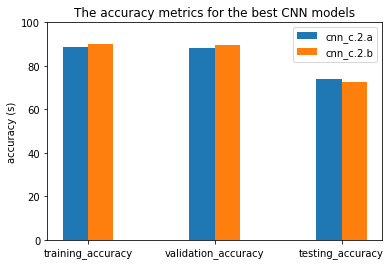

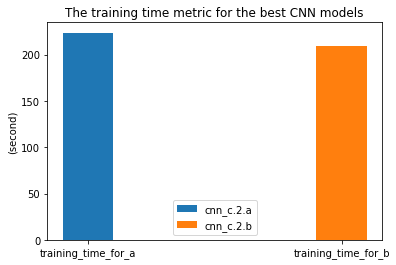

In [23]:
# collect the metrics
x_oct = np.array([2, 4, 6])
y_a_oct = [train_acc_abest, val_acc_abest, test_acc_abest]
y_b_oct = [train_acc_bbest, val_acc_bbest, test_acc_bbest]

# plot a bar graph to show the 4 metrics for both cnn models

plt.figure()
plt.bar(x_oct - 0.2, y_a_oct, width = 0.4, label = "cnn_c.2.a")
plt.bar(x_oct + 0.2, y_b_oct, width = 0.4, label = "cnn_c.2.b")
plt.xticks([2, 4, 6], ["training_accuracy", "validation_accuracy", "testing_accuracy"])
plt.ylim([0, 100])
plt.ylabel("accuracy (s)")
plt.legend()
plt.title("The accuracy metrics for the best CNN models")
plt.show()


# plot another bar graph to show the training time metric for both cnn
plt.figure()
plt.bar(1, train_time_abest, width = 0.2, label = "cnn_c.2.a")
plt.bar(2, train_time_bbest, width = 0.2, label = "cnn_c.2.b")
plt.xticks([1, 2], ["training_time_for_a", "training_time_for_b"])
plt.legend()
plt.ylabel("(second)")
plt.title("The training time metric for the best CNN models")
plt.show()


### C.3.b)

Describe at leat two observations interesting.

(i)  Through plenty of trials and compares, I find the activation function will influence the training result. In most time, when I choose ReLU as my activation function, the accuracy would usually higher than when I choose the Sigmoid function.
<br>
<br> I think the Sigmoid function has some disadvantages compared with ReLU. For example, the Sigmoid function will lead to the gradient vanish when the network becomes deeper, but the ReLU could avoid gradient vanish and gradient explosion well.
<br>
<br>
(ii)  Then, I find for all models, the training accuracy and validation accuracy would always be higher than the testing accuracy. Both training accuracy and validation accuracy could reach 90% but the testing accuracy usually stays in range 65% to 75%.
<br>
<br>  I think this phenomenon is relevant to the process of making the dataset. As the authors of "OCTMNIST" dataset said, they split 10% data from the original training dataset and use this 10% to be current validation dataset. That is to say, the validation dataset we use is a part of the training dataset we use. Therefore, it is explainable that the validation accuracy is similar to the training accuracy. However, the testing dataset we use is created by data out of the original training dataset. So, it is possible that the testing accuracy is different to training and validation accuracy.
<br>
<br>
(iii) To improve the testing accuracy, I tried several methods. I think the core is to solve the overfitting problem. Therefore, I choose to add Dropout layer, BatchNorm layer, and L2 regularization term to the models. I also used the data augmentation to horizontaly flip the original images in training dataset randomly. I find the model with a stonger regularization usually have a better testing accuracy than the one with a weak regularization. It shows the effectiveness of strengthening the regularization.
<br>
<br>
(iv)  I once used my GPU to train the models (considering the compatibilty, I remove the code to setup gpu and now the model is trained on CPU. I find that the training speed is accelerated hugely when training with a GPU. It only takes 220s to train 20 epochs with a GPU. However, if I use CPU to train the model, it will takes 200s to train only 3 epochs

# D. Unsupervised learning on Fashion-MNIST
## D.1 Dimensionality reduction and clustering

First, we load the FashionMNIST test dataset, choose two classes from it, and transform the dataset from a tensor to a numpy, which could be used for following PCA and spectral clustering.

In [24]:
# load FashionMNIST dataset
test_dataset_fashion = datasets.FashionMNIST(root = "./data", 
                                            train = False,
                                            download = True,
                                            transform = transforms.Compose([
                                                transforms.ToTensor()
                                            ]))

test_loader_fashion = DataLoader(dataset = test_dataset_fashion,
                                batch_size = len(test_dataset_fashion),
                                shuffle = False)

data_fashion = next(iter(test_loader_fashion)) # A list containing all images and labels
                                               # from test dataset of FashionMNIST
    
images_fashion, labels_fashion = data_fashion # Images_fashion is a (10000, 1, 28, 28) tensor
                                              # containing all images from test dataset of
                                              # FashionMNIST. labels_fashion is a (10000, 1)
                                              # tensor containing corresponding labels for images.

Now, we choose two classes from ten(0=T-shirt/top; 1=Trouser; 2=Pullover; 3=Dress; 4=Coat; 5=Sandal; 6=Shirt; 7=Sneaker; 8=Bag; 9=Ankle boot).

Here, we choose 4-Coat and 9-Ankle boot. Each class has 1000 images and we have 2000 images in total.
    
Then, we combine images from these two classes into a single (784x2000) numpy array.

In [25]:
c1 = [] # a list containing the coat image
c2 = [] # a list containing the Ankle image

for i in range(len(test_dataset_fashion)):
    if (labels_fashion[i] == 4):
        c1.append(images_fashion[i, :, :, :])
    if (labels_fashion[i] == 9):
        c2.append(images_fashion[i, :, :, :])

# combine all images into a 784*2000 numpy array
chosen_fashion = c1[0].view(-1, 1).numpy()

for i in range(1, len(c1)):
    chosen_fashion = np.hstack((chosen_fashion, c1[i].view(-1, 1).numpy()))
for i in range(len(c2)):
    chosen_fashion = np.hstack((chosen_fashion, c2[i].view(-1, 1).numpy()))

# transform "chosen_fashion" from 784*2000 to 2000*784 for the implementation of "PCA"
chosen_fashion = chosen_fashion.transpose()

# calculate the mean value for each pixel.
mean_chosen_fashion = np.mean(chosen_fashion, 0) # shape is (784, )

# make the mean of data in every dimension be 0
chosen_fashion = chosen_fashion - mean_chosen_fashion

### D.1.a)
    
Apply PCA to all images of these two chosen classes and visualize the top 5 eigenvector as images inthe descending order.

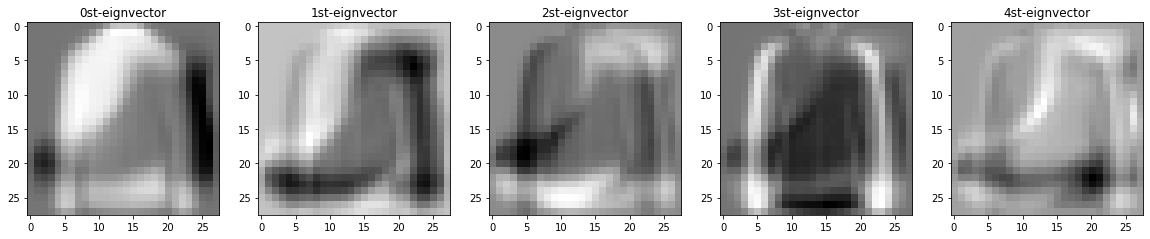

In [26]:
# define a pca by sklearn library
pca_30 = PCA(30)

chosen_fashion_pca = pca_30.fit_transform(chosen_fashion)

# display the top 5 eigenvector in descending order

plt.figure(figsize = (20, 4))
for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.title("{}st-eignvector".format(i))
    plt.imshow(pca_30.components_[i].reshape(28, 28), cmap = "gray")
plt.show()


### D.1.b)
Use the top 30 Principle Components to reconstruct 10 images, with 5 from each class (any 5 images are fine from each class).

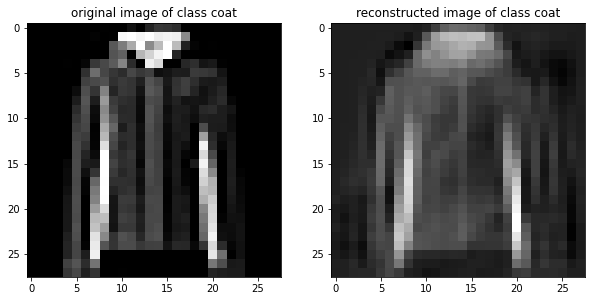

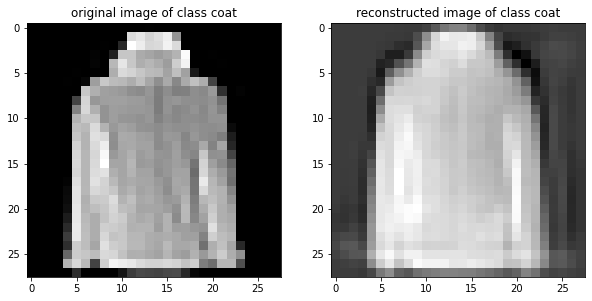

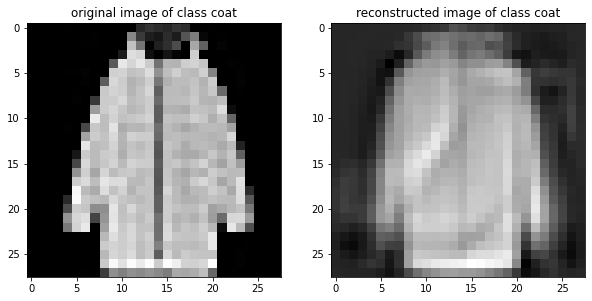

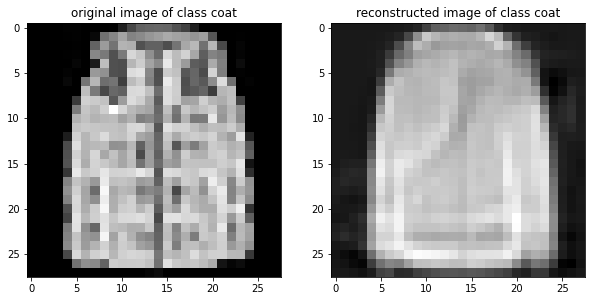

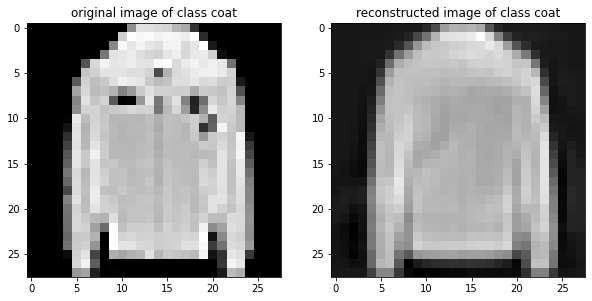

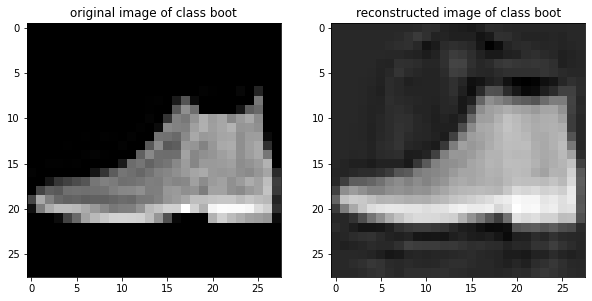

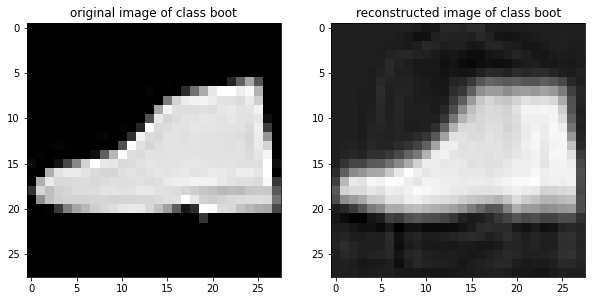

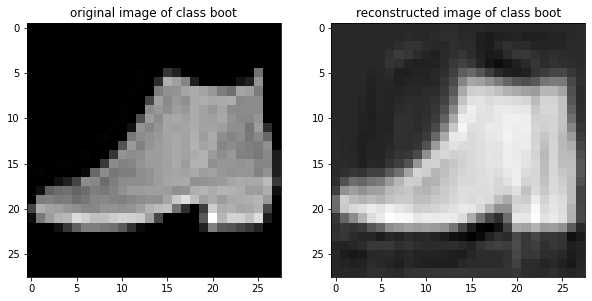

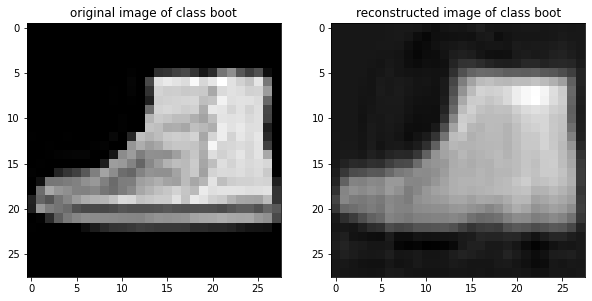

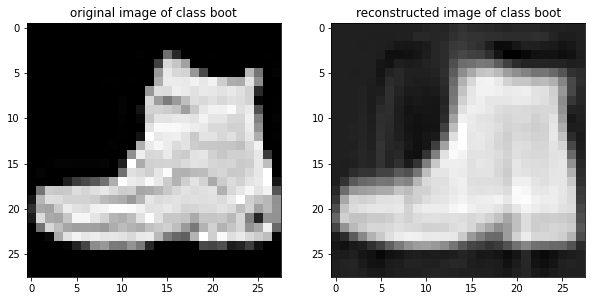

In [27]:
# get the reconstruction matrix
recon = np.array(pca_30.components_).T @ chosen_fashion_pca.T

# define a function to produce a pair of reconstructed and original images
def Pairshow_fashion(ind, cl): # ind represents the index of the image we want to inspect
                               # cl represents the class of the image we want to inspect
    plt.figure(figsize = (10, 5))
    if (cl == "coat"):
        npimg = c1[ind].numpy()
        npimg = np.transpose(npimg, [1, 2, 0])
        plt.subplot(1, 2, 1)
        plt.title("original image of class {}".format(cl))
        plt.imshow(npimg, cmap = "gray")
        plt.subplot(1, 2, 2)
        plt.title("reconstructed image of class {}".format(cl))
        plt.imshow((recon[:, ind].reshape(-1, 1) + \
                    mean_chosen_fashion.reshape(-1, 1)).reshape(28, 28), cmap = "gray")
    if (cl == "boot"):
        npimg = c2[ind].numpy()
        npimg = np.transpose(npimg, [1, 2, 0])
        plt.subplot(1, 2, 1)
        plt.title("original image of class {}".format(cl))
        plt.imshow(npimg, cmap = "gray")
        plt.subplot(1, 2, 2)
        plt.title("reconstructed image of class {}".format(cl))
        plt.imshow((recon[:, 1000 + ind].reshape(-1, 1) + \
                    mean_chosen_fashion.reshape(-1, 1)).reshape(28, 28), cmap = "gray")

# produce 10 pairs of reconstructed and original images
# produce 5 pairs for class "coat"
Pairshow_fashion(0, "coat")
Pairshow_fashion(50, "coat")
Pairshow_fashion(100, "coat")
Pairshow_fashion(200, "coat")
Pairshow_fashion(500, "coat")

Pairshow_fashion(0, "boot")
Pairshow_fashion(50, "boot")
Pairshow_fashion(100, "boot")
Pairshow_fashion(200, "boot")
Pairshow_fashion(500, "boot")

### D.1.c)

Visualize the two-dimensional PCA representations of all data points in a 2-D plane.

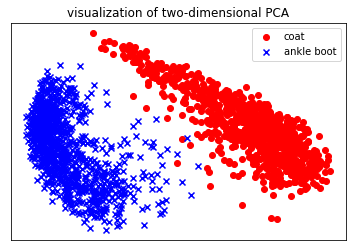

In [28]:
# reduce the dimensionality from 784 to 2
pca_c = PCA(2)
chosen_fashion_c = pca_c.fit_transform(chosen_fashion)

# visualize the two-dimensional PCA representations
plt.scatter(chosen_fashion_c[0:1000, 0], chosen_fashion_c[0:1000, 1],
           c = "red", marker = "o", 
           label = "coat") # using "ro" marker to represent data of class "coat"
plt.scatter(chosen_fashion_c[1000:2000, 0], chosen_fashion_c[1000:2000, 1], 
            c = "blue", marker = "x",
           label = "ankle boot") # using "bx" marker to represent data of class "boot"
plt.title("visualization of two-dimensional PCA")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

### D.1.d)

Use spectral clustering to cluster all data points as represented by the top two PCs. Visualize the two clusters with different colors and markers in 2D.

In [29]:
print(chosen_fashion_c.shape)

(2000, 2)


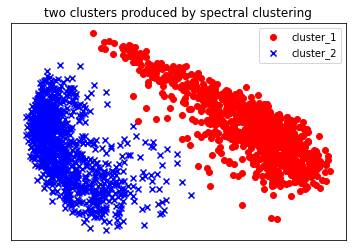

In [30]:
# define a spectral clustering object
clustering = SpectralClustering(n_clusters = 2, 
                                assign_labels = "discretize")

# last question c) has gotten the top 2 PCs, we can use it directly
unlabelled_data = chosen_fashion_c
clustering.fit(unlabelled_data)

# get the labels for each data point
clustering_label = clustering.labels_

# now, we separate unlabelled data by the labels received through spectral clustering
cluster_1_x = []
cluster_1_y = []
cluster_2_x = []
cluster_2_y = []

for i in range(len(clustering_label)):
    if (clustering_label[i] == 1):
        cluster_1_x.append(unlabelled_data[i, 0])
        cluster_1_y.append(unlabelled_data[i, 1])
    if (clustering_label[i] == 0):
        cluster_2_x.append(unlabelled_data[i, 0])
        cluster_2_y.append(unlabelled_data[i, 1])

# display two cluster with different colors and markers
plt.figure()
plt.scatter(cluster_1_x, cluster_1_y, color = "red", marker = "o", label = "cluster_1")
plt.scatter(cluster_2_x, cluster_2_y, color = "blue", marker = "x", label = "cluster_2")
plt.title("two clusters produced by spectral clustering")
plt.xticks([])
plt.yticks([])
plt.legend()
plt.show()

### D.1.e)

Now, I am going to design a autoencoder with five Conv2d layers and five ConvTranspose2d layers on all images of these two chosen classes.

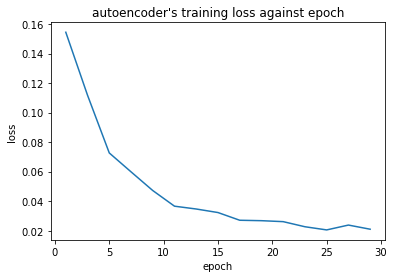

In [31]:
# prepare the dataset. I am going to create a dataloader for only the two chosen classes
twoclass_fashion = []

tenclass_fashion = list(test_dataset_fashion)

for i in range(len(test_dataset_fashion)):
    if (tenclass_fashion[i][1] == 4) or (tenclass_fashion[i][1] == 9):
        twoclass_fashion.append(tenclass_fashion[i])

        
# set the basic parameters for training autoencoder
batch_size_fashion = 50
max_epochs_fashion = 30
learning_rate_fashion = 0.001
weight_decay_fashion = 0.00001


twoclass_loader_fashion = DataLoader(dataset = twoclass_fashion,
                                    shuffle = True,
                                    batch_size = batch_size_fashion)

# define the autoencoder class
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, 3, stride = 2, padding = 1), nn.ReLU(),
            nn.Conv2d(4, 8, 3, stride = 2, padding = 1), nn.ReLU(),
            nn.Conv2d(8, 16, 3), nn.ReLU(),
            nn.Conv2d(16, 32, 3), nn.ReLU(),
            nn.Conv2d(32, 64, 3)
        )
        
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3), nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3), nn.ReLU(),
            nn.ConvTranspose2d(16, 8, 3), nn.ReLU(),
            nn.ConvTranspose2d(8, 4, 3, stride = 2, padding = 1, output_padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(4, 1, 3, stride = 2, padding = 1, output_padding = 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        
        return x

    
# create an autoencoder object and set the optimizer and loss function
myAE = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(myAE.parameters(), lr = learning_rate_fashion,
                      weight_decay = weight_decay_fashion)

# train the autoencoder by chosen two images class
epoch_num_fashion = []
ae_loss_fashion = []
for epoch in range(max_epochs_fashion):
    for data in twoclass_loader_fashion:
        imgs, labs = data
        optimizer.zero_grad()
        recons = myAE(imgs)
        loss = criterion(recons, imgs)
        loss.backward()
        optimizer.step()
    
    if (epoch % 2 ) == 0:
        epoch_num_fashion.append(epoch+1)
        ae_loss_fashion.append(loss.item())
        

# plot the loss against epoch
plt.figure()
plt.plot(epoch_num_fashion, ae_loss_fashion)
plt.title("autoencoder's training loss against epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

## D.2 Observation
Describe at least two observations interesting.

(i) To some extent, what the autoencoder is doing is like PCA. Specifically, the encoder reduces the dimensionality of images by convolution downsample. Then after several convolutional layers, the encoder could obtain some low-dimensional "high-level" features of input images. 
<br>
<br> Then, the task of decoder is like the process of reconstruction in a PCA. The low-dimensional high-level image features are operated by some trained tranposed convolutional layers and we could get reconstructed images by the decoder.
<br>
<br> In my opinion, the underlying principle of autoencoder is just like a special convolutional neural network. Rather than using the labels we usually see, it uses the input image itself as the training standard (label). 
<br>
<br>

(ii) I tried to visualize the top 2 principle components of different class in the question D.1.c). 
<br>
<br>I find that if I choose two classes with similar shapes, for example, the "shirt" class and "coat" class. Then part of their top 2 principle components will mixed together in a 2-D plane. But if I choose two classes with apparently different shapes, such as the "ankle boots" class and "coat" class. Then their top 2 principle components will be split obviously.

<br>
<br>
(iii) Through completing the assignment about PCA, I find that, to some extent, the eignvectors for a dataset in PCA are similar to a new set of coordinates basis. If we assume the old coordinate basis (in our assignment, there are 784 basis for 2000 images) represent the old features for image dataset. Then the PCA could help us find the eignvectors and these eignvectors are a new set of coordinate basis to represent a new set of features for the images dataset. These new features could separate the images in different classes more easily because the covariances between these new set of features are almost zero. These new sets of features contain more information to be used to classify images datasets.
<br>
<br>
(iv) In the question d.1.b to reconstruct images by top 30 PCs, we could find that some reconstructed coat images contain the shadow of "ankle boots", and similarly, some reconstructed ankle boots images contain the shawdow of "coat". I think it is because we fit the PCA model by using a dataset containing both "boots" and "coat" images. Therefore, the eignvectors would contain both the information of "coat" and "boots". When we use the eignvectors to reconstruct the images, the reconstructed images will inevitably receive the information out of their class.